###  1. Import Libraries

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors


### 2. Load Dataset

In [30]:
import pandas as pd

# Load the CSV files
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')

# Quick look at the data
print("Movies:")
print(movies.head(), "\n")

print("Ratings:")
print(ratings.head(), "\n")

print("Tags:")
print(tags.head(), "\n")

print("Links:")
print(links.head(), "\n")


Movies:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy   

Ratings:
   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858 

Tags:
   userId  movieId          tag   timestamp
0      22    26479  Kevin Kline  1583038886
1      22    79592     misogyny  1581476297
2      22   247150

In [31]:
# Merge ratings with movie titles
data = pd.merge(ratings, movies, on='movieId')

### Exploratory Data Analysis (EDA)

In [33]:
print("Data Overview:")
print(data.head())

Data Overview:
   userId  movieId  rating   timestamp                         title  \
0       1       17     4.0   944249077  Sense and Sensibility (1995)   
1       3       17     5.0  1084485217  Sense and Sensibility (1995)   
2      15       17     4.5  1289858271  Sense and Sensibility (1995)   
3      28       17     4.0   961513829  Sense and Sensibility (1995)   
4      29       17     4.0   845056111  Sense and Sensibility (1995)   

          genres  
0  Drama|Romance  
1  Drama|Romance  
2  Drama|Romance  
3  Drama|Romance  
4  Drama|Romance  


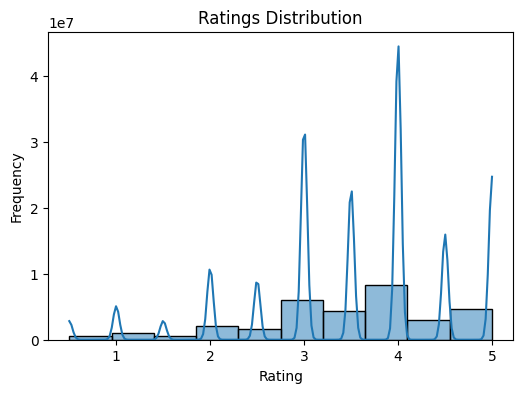


Top 10 Most Rated Movies:
title
Shawshank Redemption, The (1994)                             102929
Forrest Gump (1994)                                          100296
Pulp Fiction (1994)                                           98409
Matrix, The (1999)                                            93808
Silence of the Lambs, The (1991)                              90330
Star Wars: Episode IV - A New Hope (1977)                     85010
Fight Club (1999)                                             77332
Jurassic Park (1993)                                          75233
Schindler's List (1993)                                       73849
Lord of the Rings: The Fellowship of the Ring, The (2001)     73122
dtype: int64


In [41]:
# Ratings distribution
plt.figure(figsize=(6,4))
sns.histplot(data['rating'], bins=10, kde=True)
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Number of ratings per movie
ratings_per_movie = data.groupby('title').size().sort_values(ascending=False)

# Top 10 most rated movies
print("\nTop 10 Most Rated Movies:")
print(ratings_per_movie.head(10))

### Content-Based Filtering

In [56]:
# Fill NaNs in genres with empty string
movies['genres'] = movies['genres'].fillna('')

# TF-IDF Vectorizer on genres
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# Using Nearest Neighbors instead of full cosine similarity matrix to avoid memory error
nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(tfidf_matrix)

# Build a reverse map of indices and movie titles
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

# Recommendation Function using Nearest Neighbors
def content_recommendations(title, n=10):
    if title not in indices:
        return "Movie not found in database."
    idx = indices[title]
    distances, indices_nn = nn.kneighbors(tfidf_matrix[idx], n_neighbors=n+1)
    movie_indices = indices_nn.flatten()[1:]  # Exclude the movie itself
    return movies['title'].iloc[movie_indices]

# Example usage
print("\nTop 10 recommendations for 'Toy Story (1995)'):")
print(content_recommendations('Toy Story (1995)'))


Top 10 recommendations for 'Toy Story (1995)'):
80560       Riverdance: The Animated Adventure (2021)
70958             The Snow Queen: Mirror Lands (2018)
60252                              Wonder Park (2019)
78015         My Little Pony: A New Generation (2021)
53485               Tangled: Before Ever After (2017)
60260                             Missing Link (2019)
0                                    Toy Story (1995)
53494                           Trolls Holiday (2017)
49160    Puss in Book: Trapped in an Epic Tale (2017)
83783                       My Father's Dragon (2022)
Name: title, dtype: object


### Collaborative Filtering using Pivot Table

In [71]:
# Filter to avoid large matrix creation
popular_movies = ratings['movieId'].value_counts().head(1000).index
active_users = ratings['userId'].value_counts().head(1000).index
filtered_ratings = ratings[(ratings['movieId'].isin(popular_movies)) & (ratings['userId'].isin(active_users))]

user_movie_matrix = filtered_ratings.pivot(index='userId', columns='movieId', values='rating')
user_movie_matrix.fillna(0, inplace=True)

# Compute user-user similarity
user_similarity = cosine_similarity(user_movie_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)


### Movie Recommendation Function for a User

In [74]:
def get_similar_users(user_id, n=5):
    return user_similarity_df[user_id].sort_values(ascending=False)[1:n+1].index.tolist()

def recommend_movies_for_user(user_id, n=5):
    if user_id not in user_movie_matrix.index:
        print(f"User {user_id} not found in the filtered dataset. Available user IDs range from {user_movie_matrix.index.min()} to {user_movie_matrix.index.max()}.")
        return pd.Series(["No recommendations available."], name="Recommendation")
    similar_users = get_similar_users(user_id, n)
    similar_users_ratings = user_movie_matrix.loc[similar_users]
    user_ratings = user_movie_matrix.loc[user_id]
    recommendations = similar_users_ratings.mean().sort_values(ascending=False)
    recommendations = recommendations[user_ratings == 0]  # Recommend only unseen movies
    movie_titles = movies.set_index('movieId').loc[recommendations.index]['title']
    return movie_titles.head(10)

# Example
print("\nTop 10 movie recommendations for user 1:")
print(recommend_movies_for_user(1))


Top 10 movie recommendations for user 1:
User 1 not found in the filtered dataset. Available user IDs range from 28 to 200578.
0    No recommendations available.
Name: Recommendation, dtype: object
